<a href="https://colab.research.google.com/github/Tasfiq23/Sentiment-analysis-using-tensorflow/blob/main/Sentiment_analysis_using_Universal_sentence_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from pathlib import Path
from tarfile import TarFile
from bs4 import BeautifulSoup
import io
import pandas as pd
import numpy as np
import tensorflow_hub as hub


# download tar with psuedo XML...
url = "http://www.cs.jhu.edu/%7Emdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
fn = Path.cwd().joinpath(url.split("/")[-1])
if not fn.exists():
    r = requests.get(url, stream=True)
    with open(fn, 'wb') as f:
        for chunk in r.raw.stream(1024, decode_content=False):
            if chunk:
                f.write(chunk)

# untar downloaded file and generate a dictionary of all files
TarFile.open(fn, "r:gz").extractall()
files = {f"{p.parent.name}/{p.name}":p for p in Path.cwd().joinpath("sorted_data_acl").glob("**/*") if p.is_file()}

# convert all files into dataframes in a dict
dfs = {}
for file in files.keys():
    with open(files[file]) as f: text = f.read()
    # psuedo xml where there is not root element stops it from being well formed
    # force it in...
    soup = BeautifulSoup(f"<root>{text}</root>", "xml")
    # simple case of each review is a row and each child element is a column
    dfs[file] = pd.DataFrame([{c.name:c.text.strip("\n") for c in r.children if c.name} for r in soup.find_all("review")])



In [ ]:
positive_reviews=[]
negative_reviews=[]

for k,v in dfs.items():
 
  if k.split('/')[1] == "positive.review": 
    positive_reviews.append(v)
  elif k.split('/')[1] == "negative.review":
    negative_reviews.append(v)
type(negative_reviews[3])

pandas.core.frame.DataFrame

In [ ]:
df_neg = pd.concat([negative_reviews[0],negative_reviews[1],negative_reviews[2],negative_reviews[3]])
df_pos = pd.concat([positive_reviews[0],positive_reviews[1],positive_reviews[2],positive_reviews[3]])

In [ ]:
#Adding class column for positive and negative
df_pos['class']= 'Pos'
df_neg['class']= 'Neg'


In [ ]:
df = pd.concat([df_pos,df_neg],ignore_index=True)



,unique_id,asin,product_name,product_type,helpful,rating,title,date,reviewer,reviewer_location,review_text,class
0,B00068N1DO:perfectly_fits_the_books'_atmospher...,B00068N1DO,Lemony Snicket's A Series of Unfortunate Event...,kitchen housewares,,5.0,Perfectly fits the books' atmosphere,"October 17, 2004","C. MCCALLISTER ""dr_dolphin""",The waters of the Great Lakes,"For those of you unfamiliar with the ""A Series...",Pos
1,B000634GCO:no_more_doggy_fueds_with_neighbor:e...,B000634GCO,Stationary Bark Control by Petsafe: Kitchen H...,kitchen housewares,6 of 6,5.0,no more doggy fueds with neighbor,"December 30, 2005",E. Patterson,california,i absolutely love this product. my neighbor ha...,Pos
2,B0006PK1D0:worked_for_us:gadget_mom,B0006PK1D0,Reporter WireFree Intercom System: Kitchen Ho...,kitchen housewares,,4.0,Worked for us,"November 3, 2006",Gadget Mom,NY,I purchased 3 units and they work well for us....,Pos
3,B00009K3V1:new_fry-guy_-_pretty_pleased....:br...,B00009K3V1,"Waring DF200 Professional Deep Fryer, Brushed ...",kitchen housewares,8 of 9,4.0,New Fry-guy - pretty pleased....,"July 7, 2006",Brian W. Hodgman,Midwest,"I've always wanted a deep fryer, and finally d...",Pos
4,"B00009K3V1:excellent_fryer:j._white_""janinenc""",B00009K3V1,"Waring DF200 Professional Deep Fryer, Brushed ...",kitchen housewares,2 of 2,5.0,Excellent fryer,"July 3, 2006","J. White ""janinenc""",OR United States,"Easy to use, easy to clean. Two major requirem...",Pos
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0385514573:a_nice_place_to_visit....:nina_shis...,0385514573,Deadly Slipper: A Novel of Death in the Dordog...,books,5 of 10,2.0,a nice place to visit....,"February 25, 2006","Nina Shishkoff ""mycologist""","Mount Airy, MD","If I had been an editor and received ""Deadly S...",Neg
7996,0385514573:boring:o._gonzalez,0385514573,Deadly Slipper: A Novel of Death in the Dordog...,books,2 of 3,1.0,boring,"July 30, 2005",O. Gonzalez,"Ashburn, VA",This book is very disappointing. The writing i...,Neg
7997,"097160200X:lacking:m._roman_""matt1234567""",097160200X,Sitting Pretty: Looking and Feeling Better Wit...,books,7 of 7,1.0,Lacking,"May 3, 2005","M. Roman ""matt1234567""",,I was extremely disappointed by this book/pamp...,Neg
7998,"1564147363:okay_for_ideas:stacy_e._burrell_""st...",1564147363,The 100 Best Businesses to Start When You Don'...,books,22 of 22,2.0,Okay for ideas,"March 23, 2005","Stacy E. Burrell ""Stacy's Blog (See stacyburre...","Detroit, MI USA",This book is the typical package of business i...,Neg


# Using universal-sentence-encoder

In [ ]:
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

     |████████████████████████████████| 4.3 MB 5.2 MB/s 


In [ ]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(df["class"].to_numpy().reshape(-1, 1))

In [ ]:
X , y = df['review_text'],df['class']

X.to_numpy()
y.to_numpy()

from sklearn.model_selection import train_test_split

train_review, test_review, y_train, y_test = train_test_split(X, type_one_hot, test_size=0.2, random_state=42)

In [ ]:
from tqdm import tqdm
import tensorflow as tf

X_train = []
for r in tqdm(train_review):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

X_test = []
for r in tqdm(test_review):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)



100%|██████████| 1600/1600 [07:40<00:00,  3.48it/s]


In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6400, 512) (1600, 512)
(6400, 2) (1600, 2)


In [ ]:
from tensorflow import keras
from keras import regularizers

model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    kernel_regularizer=regularizers.l2(0.001),
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)


model.add(
  keras.layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l2(0.001),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
360/360 [==============================] - 2s 4ms/step - loss: 0.8035 - accuracy: 0.7243 - val_loss: 0.6101 - val_accuracy: 0.7750
Epoch 2/10
360/360 [==============================] - 1s 4ms/step - loss: 0.5822 - accuracy: 0.7948 - val_loss: 0.5633 - val_accuracy: 0.7875
Epoch 3/10
360/360 [==============================] - 1s 4ms/step - loss: 0.5325 - accuracy: 0.8087 - val_loss: 0.5313 - val_accuracy: 0.7906
Epoch 4/10
360/360 [==============================] - 1s 3ms/step - loss: 0.5077 - accuracy: 0.8127 - val_loss: 0.5431 - val_accuracy: 0.7719
Epoch 5/10
360/360 [==============================] - 1s 4ms/step - loss: 0.4934 - accuracy: 0.8174 - val_loss: 0.5388 - val_accuracy: 0.7734
Epoch 6/10
360/360 [==============================] - 1s 3ms/step - loss: 0.4849 - accuracy: 0.8245 - val_loss: 0.5360 - val_accuracy: 0.7891
Epoch 7/10
360/360 [==============================] - 1s 4ms/step - loss: 0.4735 - accuracy: 0.8318 - val_loss: 0.5447 - val_accuracy: 0.7734
Epoch 

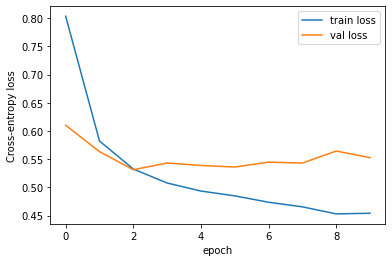

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();